# POC Loan Rates Forecast Model

# 1. Executive Summary

# 2. Model Information

# 3. Conceptual Soundness 

# 4. Model Development

## 4.1. Data Engineering

### 4.1.1. Data Collection

#### Setup

In [52]:
# ML libraries
import pandas as pd
import xgboost as xgb
from numpy import argmax
from sklearn.metrics import accuracy_score, precision_recall_curve
from sklearn.model_selection import train_test_split

# Plotting libraries 
import matplotlib.pyplot as plt
%matplotlib inline

#### Load Loan Rates

In [53]:
loan_rates_raw = pd.read_csv("../datasets/lending_club_loan_rates.csv", sep='\t')
loan_rates_raw = loan_rates_raw.rename(columns={'Unnamed: 0': 'Date'})
loan_rates_raw = loan_rates_raw.set_index(pd.to_datetime(loan_rates_raw['Date']))
loan_rates_raw.drop(["Date"], axis=1, inplace=True)

In [54]:
# Select only loan rates 
columns_to_select = [
    "loan_rate_A",
    "loan_rate_B",
    "loan_rate_C",
    "loan_rate_D",
]
loan_rates_raw = loan_rates_raw.loc[:, columns_to_select]
loan_rates_raw.head()

,loan_rate_A,loan_rate_B,loan_rate_C,loan_rate_D
Date,,,,
2007-08-01,7.766667,9.497692,10.947500,12.267000
2007-09-01,7.841429,9.276667,10.829167,12.436667
2007-10-01,7.830000,9.433333,10.825926,12.737368
2007-11-01,7.779091,9.467778,10.967037,12.609444
2007-12-01,7.695833,9.387500,10.805000,12.478889


In [55]:
loan_rates_resample = loan_rates_raw.resample('M').ffill()
loan_rates_resample.head()

,loan_rate_A,loan_rate_B,loan_rate_C,loan_rate_D
Date,,,,
2007-08-31,7.766667,9.497692,10.947500,12.267000
2007-09-30,7.841429,9.276667,10.829167,12.436667
2007-10-31,7.830000,9.433333,10.825926,12.737368
2007-11-30,7.779091,9.467778,10.967037,12.609444
2007-12-31,7.695833,9.387500,10.805000,12.478889


In [56]:
tmp = loan_rates_resample.asfreq('M')
tmp.head()

,loan_rate_A,loan_rate_B,loan_rate_C,loan_rate_D
Date,,,,
2007-08-31,7.766667,9.497692,10.947500,12.267000
2007-09-30,7.841429,9.276667,10.829167,12.436667
2007-10-31,7.830000,9.433333,10.825926,12.737368
2007-11-30,7.779091,9.467778,10.967037,12.609444
2007-12-31,7.695833,9.387500,10.805000,12.478889


#### Load FRED Macroeconomic Variables

In [57]:
import pandas as pd
import glob

def merge_fred_csv_files(file_pattern):
    # Use glob to find all files matching the specified pattern
    file_list = glob.glob(file_pattern)

    # Initialize an empty list to store individual DataFrames
    dataframes = []

    # Iterate through each file in the file list
    for file in file_list:
        # Read the CSV file into a DataFrame
        df = pd.read_csv(file, parse_dates=['DATE'], index_col='DATE')

        # Add the DataFrame to the list of DataFrames
        dataframes.append(df)

    # Merge all the DataFrames in the list into a single DataFrame
    merged_df = pd.concat(dataframes, axis=1)

    return merged_df


In [58]:
file_pattern = '../datasets/fred/*.csv'
df_fred = merge_fred_csv_files(file_pattern)
display(df_fred)

,GDPC1,GS5,GS3,FEDFUNDS,GDP
DATE,,,,,
1947-01-01,2034.450,NaN,NaN,NaN,243.164
1947-04-01,2029.024,NaN,NaN,NaN,245.968
1947-07-01,2024.834,NaN,NaN,NaN,249.585
1947-10-01,2056.508,NaN,NaN,NaN,259.745
1948-01-01,2087.442,NaN,NaN,NaN,265.742
...,...,...,...,...,...
2022-11-01,NaN,4.06,4.34,3.78,NaN
2022-12-01,NaN,3.76,4.05,4.10,NaN
2023-01-01,20235.878,3.64,3.91,4.33,26465.865


#### Merge Loan Rates and Macroecnonomic Variables

In [59]:
df = pd.merge(loan_rates_raw, df_fred, left_index=True, right_index=True, how='inner')
df.head()

,loan_rate_A,loan_rate_B,loan_rate_C,loan_rate_D,GDPC1,GS5,GS3,FEDFUNDS,GDP
2007-08-01,7.766667,9.497692,10.947500,12.267000,NaN,4.43,4.34,5.02,NaN
2007-09-01,7.841429,9.276667,10.829167,12.436667,NaN,4.20,4.06,4.94,NaN
2007-10-01,7.830000,9.433333,10.825926,12.737368,15767.146,4.20,4.01,4.76,14715.058
2007-11-01,7.779091,9.467778,10.967037,12.609444,NaN,3.67,3.35,4.49,NaN
2007-12-01,7.695833,9.387500,10.805000,12.478889,NaN,3.49,3.13,4.24,NaN


### 4.1.2. Data Description

In [60]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 137 entries, 2007-08-01 to 2018-12-01
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   loan_rate_A  137 non-null    float64
 1   loan_rate_B  137 non-null    float64
 2   loan_rate_C  137 non-null    float64
 3   loan_rate_D  137 non-null    float64
 4   GDPC1        45 non-null     float64
 5   GS5          137 non-null    float64
 6   GS3          137 non-null    float64
 7   FEDFUNDS     137 non-null    float64
 8   GDP          45 non-null     float64
dtypes: float64(9)
memory usage: 10.7 KB


### 4.1.3. Data Quality

#### Missing Values

Total number of missing values.

In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def plot_missing_values_bar(df):
    """
    Plot a bar chart displaying the total number of missing values per variable (column) in a time-series DataFrame using seaborn.
    
    :param df: Time-series DataFrame
    """
    # Calculate the total number of missing values per column
    missing_values = df.isnull().sum()

    # Set seaborn plot style
    sns.set(style="darkgrid")

    # Plot the bar chart
    plt.figure(figsize=(12, 6))
    sns.barplot(x=missing_values.index, y=missing_values.values)
    
    plt.xticks(rotation=45, ha='right')
    plt.xlabel('Variables (Columns)')
    plt.ylabel('Number of Missing Values')
    plt.title('Total Number of Missing Values per Variable')
    plt.show()

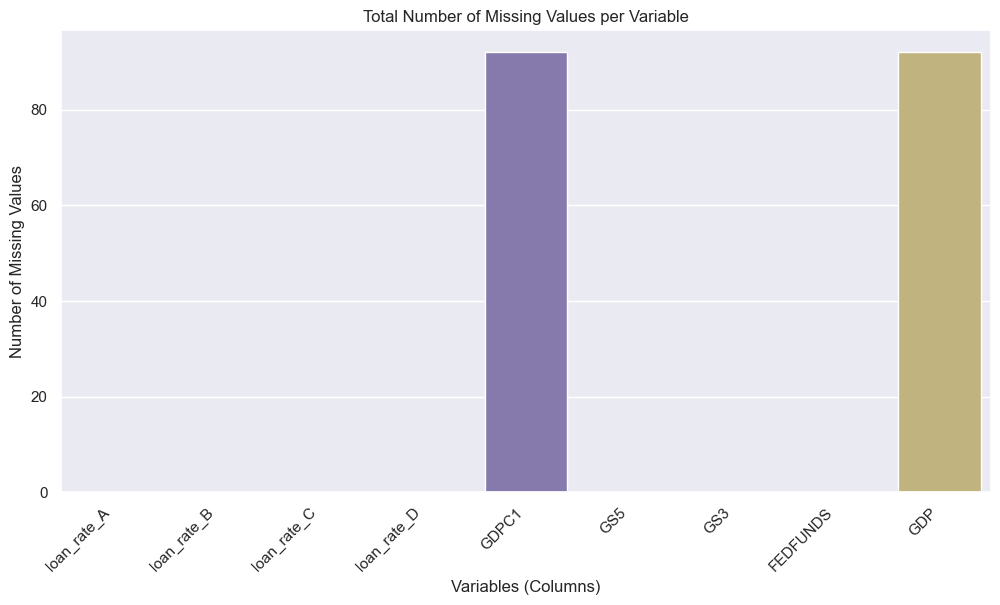

In [62]:
plot_missing_values_bar(df)

Heatmap of missing values.

In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def plot_missing_values_heatmap(df):
    """
    Plot a heatmap of missing values with actual years in rows using seaborn.
    
    :param df: Time-series DataFrame
    """
    # Create a boolean mask for missing values
    missing_mask = df.isnull()

    # Set seaborn plot style
    sns.set(style="darkgrid")

    # Plot the heatmap
    plt.figure(figsize=(12, 6))
    sns.heatmap(missing_mask.T, cmap='viridis', cbar=False, xticklabels=False)

    # Add actual years on the x-axis
    years = df.index.year.unique()
    xticks = [df.index.get_loc(df.index[df.index.year == year][0]) for year in years]
    plt.xticks(xticks, years, rotation=45, ha='right')

    plt.ylabel('Columns')
    plt.xlabel('Rows (Years)')
    plt.title('Missing Values Heatmap with Actual Years in Rows')
    plt.show()


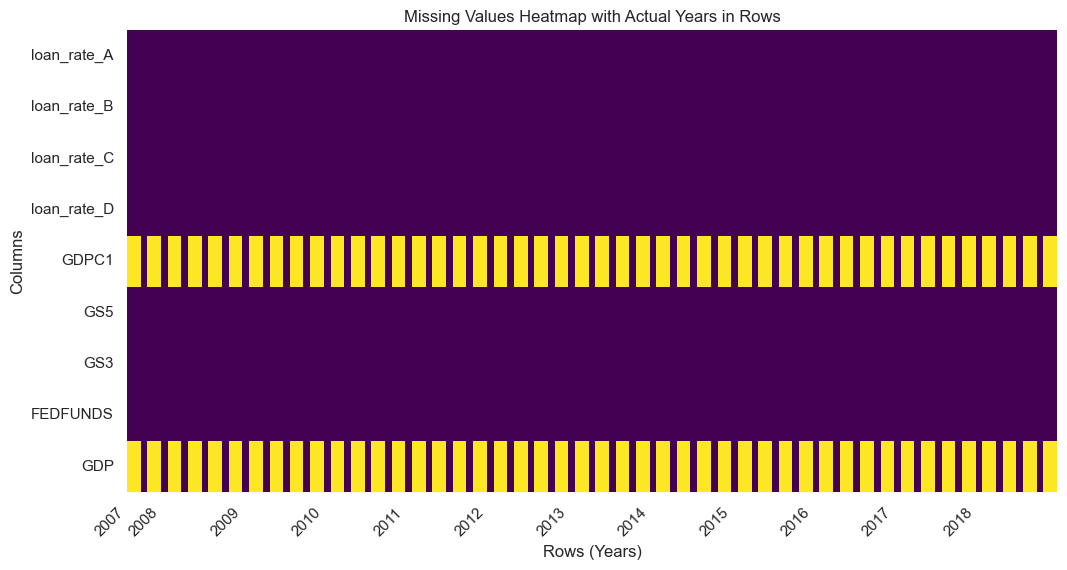

In [64]:
plot_missing_values_heatmap(df)

Drop missing values.

In [65]:
df = df.dropna()

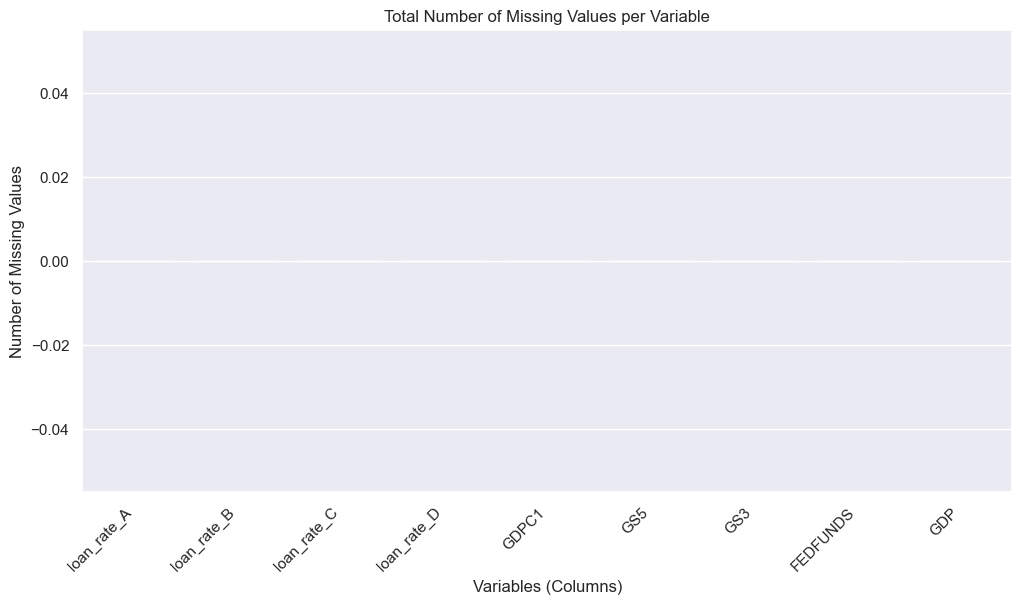

In [66]:
plot_missing_values_bar(df)

#### Outliers

#### Frequency of the Series

In [67]:
print(df.index.freq)

None


In [68]:
# Resample the DataFrame to fill in missing data points
df = df.resample('Q').ffill()

# Set the frequency of the DataFrame to monthly using 'asfreq()'
df = df.asfreq('Q')

In [69]:
print(df.index.freq)

<QuarterEnd: startingMonth=12>


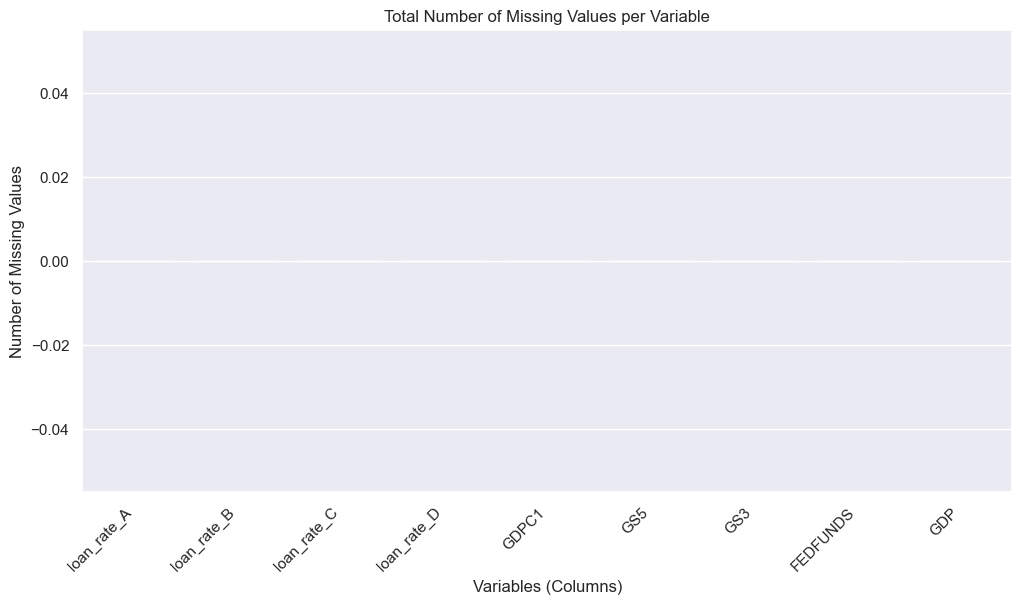

In [70]:
plot_missing_values_bar(df)

## 4.2. Exploratory Data Analysis

### 4.2.1. Univariate Analysis

#### Visual Inspection

Line plots.

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def plot_time_series(df, cols_to_plot, title=''):
    """
    Plot multiple time-series in the same axes using seaborn.
    
    :param df: DataFrame with time-series data
    :param cols_to_plot: List of column names to plot
    :param title: Title of the plot, default is ''
    """
    # Create a new DataFrame with the columns to plot
    plot_df = df[cols_to_plot]

    # Set seaborn plot style
    sns.set(style="darkgrid")

    # Plot the time-series data
    plt.figure(figsize=(12, 6))
    for col in plot_df.columns:
        sns.lineplot(data=plot_df[col], label=col)

    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.title(title)
    plt.legend()
    plt.show()

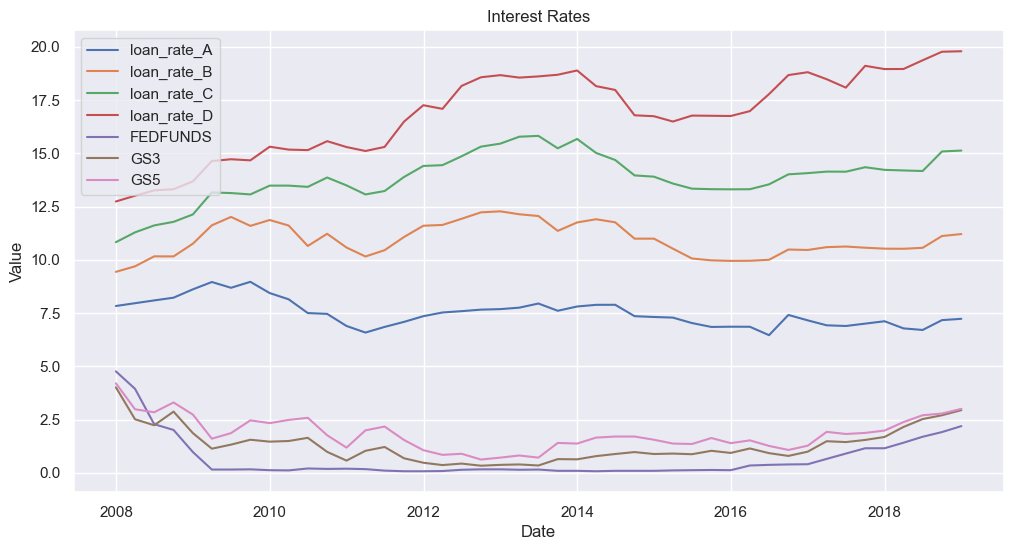

In [71]:
interest_rates = ['loan_rate_A', 'loan_rate_B', 'loan_rate_C', 'loan_rate_D', 'FEDFUNDS', 'GS3', 'GS5']
plot_time_series(df, interest_rates, title='Interest Rates')

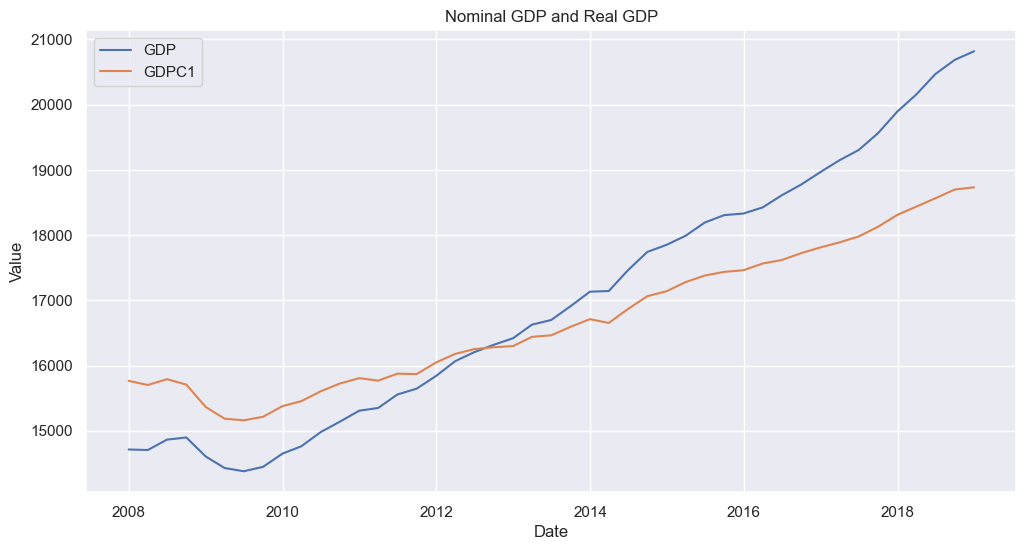

In [72]:
gdp = ['GDP','GDPC1']
plot_time_series(df, gdp, title='Nominal GDP and Real GDP')

#### Seasonality 

Compute seasonal decomposition.

In [76]:
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose

def compute_seasonal_decomposition(data, period):
    """
    Compute seasonal decomposition for all time-series in a DataFrame and store all the components in a new DataFrame.
    
    :param data: DataFrame with time-series data
    :param period: Number of observations in each seasonal period
    :return: DataFrame with seasonal, trend, and residual components for all time-series in the input DataFrame
    """
    # Initialize an empty DataFrame to store the components for each time-series
    decomp_df = pd.DataFrame()

    # Loop over each column in the input DataFrame and perform seasonal decomposition
    for col in data.columns:
        res = seasonal_decompose(data[col], model='additive', period=period)
        decomp_df[f'{col}_seasonal'] = res.seasonal
        decomp_df[f'{col}_trend'] = res.trend
        decomp_df[f'{col}_residual'] = res.resid

    # Set the index of the decomposed DataFrame to be the same as the input DataFrame
    decomp_df.index = data.index

    return decomp_df


In [80]:
decomp_df = compute_seasonal_decomposition(df, period=4)

In [82]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_seasonal_components(decomp_df):
    """
    Plot all seasonal, trend, and residual components for each variable in a DataFrame.
    
    :param decomp_df: DataFrame with seasonal, trend, and residual components for each variable
    """
    # Initialize a figure with subplots for each variable and component
    fig, axs = plt.subplots(nrows=len(decomp_df.columns) // 3, ncols=3, figsize=(12, 4 * (len(decomp_df.columns) // 3)))

    # Loop over each variable in the input DataFrame and plot the seasonal, trend, and residual components
    for i, col in enumerate(decomp_df.columns[::3]):
        axs[i, 0].plot(decomp_df.index, decomp_df[f'{col}'])
        axs[i, 0].set_title(f'Seasonal: {col[:-9]}')
        axs[i, 1].plot(decomp_df.index, decomp_df[f'{col[:-9]}_trend'])
        axs[i, 1].set_title(f'Trend: {col[:-9]}')
        axs[i, 2].plot(decomp_df.index, decomp_df[f'{col[:-9]}_residual'])
        axs[i, 2].set_title(f'Residual: {col[:-9]}')

    # Set the figure title
    fig.suptitle('Seasonal Decomposition', fontsize=16)

    # Adjust the spacing between subplots
    fig.tight_layout()

    # Show the plot
    plt.show()

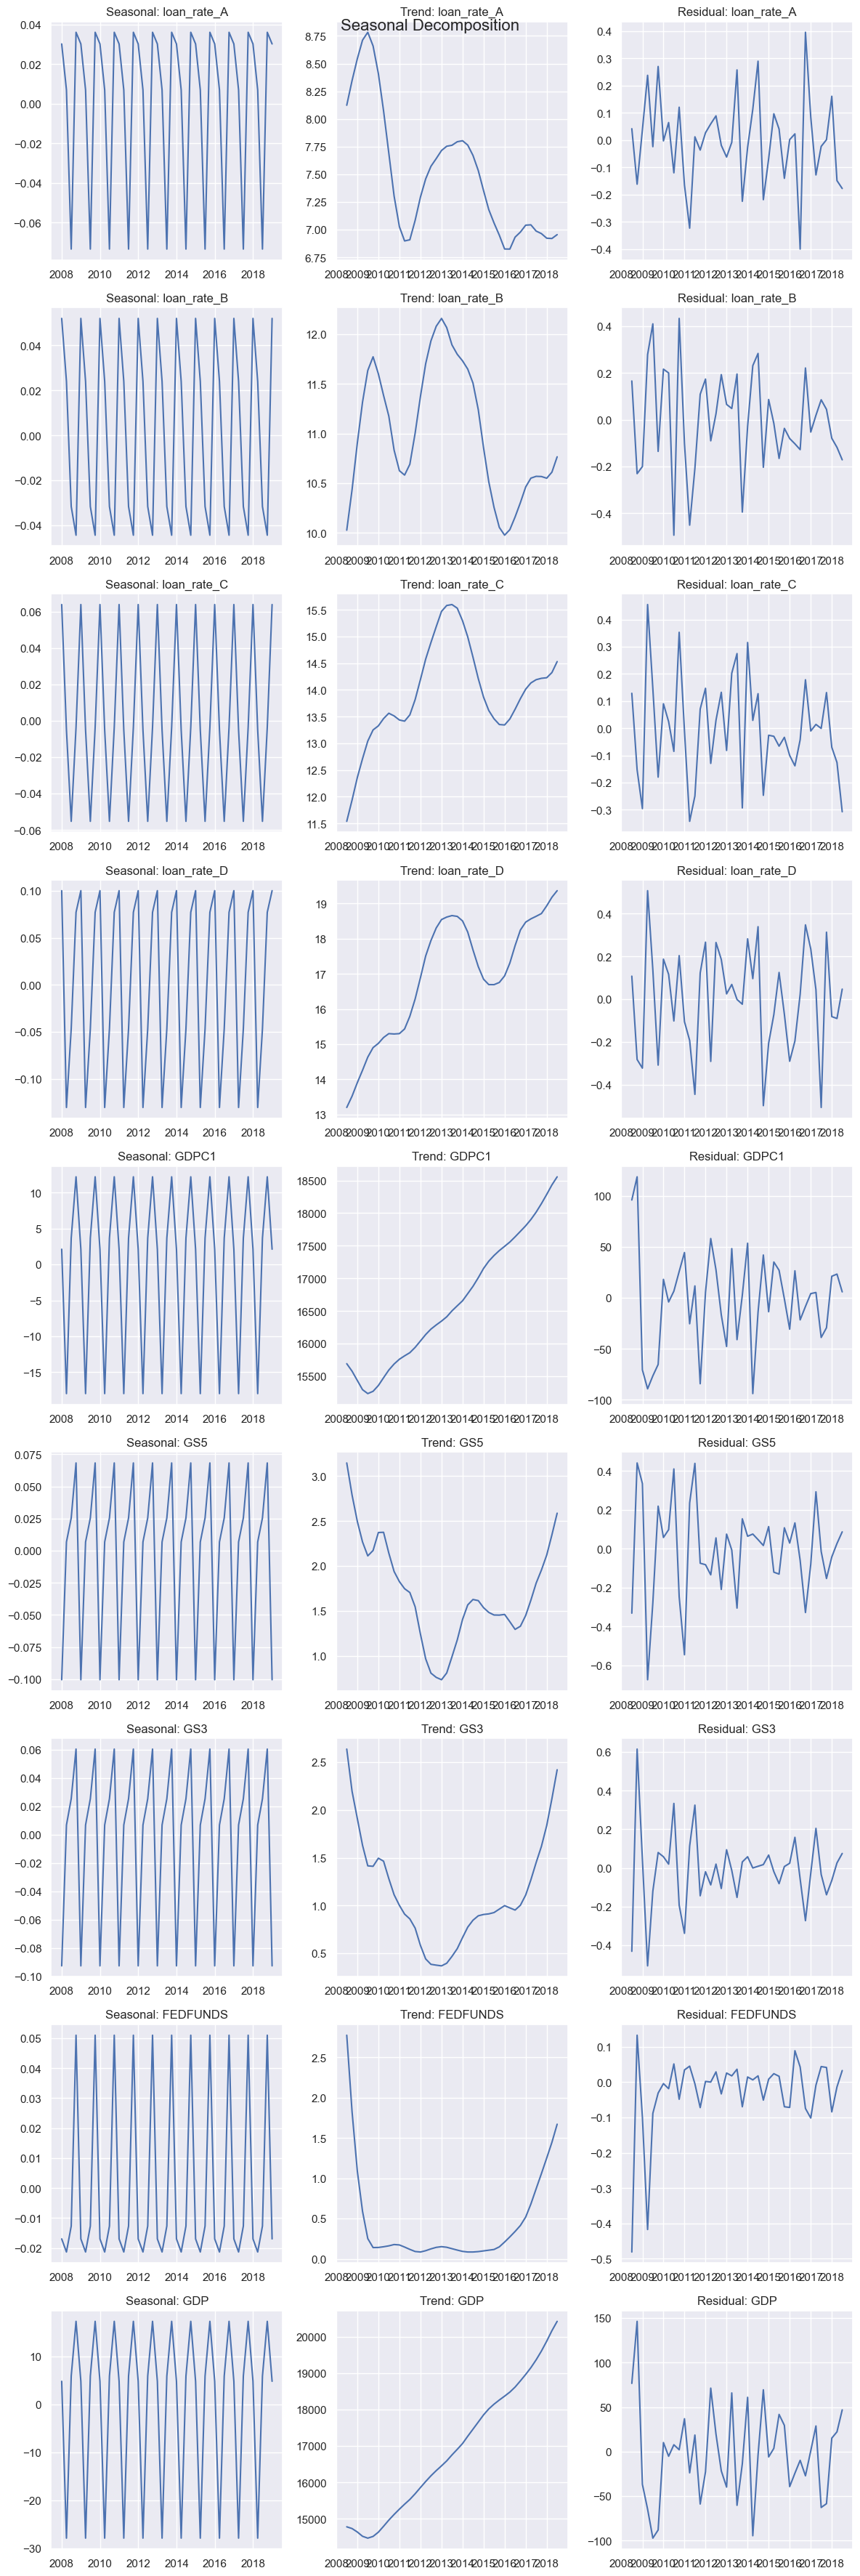

In [83]:
plot_seasonal_components(decomp_df)

#### Stationarity

In [114]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller, kpss
from arch.unitroot import PhillipsPerron, ZivotAndrews, DFGLS

def test_stationarity(data, threshold=0.05):
    """
    Perform multiple stationarity tests on each time series in a DataFrame.
    
    :param data: DataFrame with time-series data
    :return: DataFrame with test results (Variable, Test, p-value, Threshold, Pass/Fail, Decision)
    """
    # Initialize an empty DataFrame to store the test results
    test_results = pd.DataFrame(columns=['Variable', 'Test', 'p-value', 'Threshold', 'Pass/Fail', 'Decision'])

    # Loop over each column in the input DataFrame and perform stationarity tests
    for col in data.columns:
        # Perform the ADF test
        adf_result = adfuller(data[col], autolag='AIC')
        adf_pvalue = adf_result[1]
        adf_pass_fail = adf_pvalue < threshold
        adf_decision = 'Stationary' if adf_pass_fail else 'Non-stationary'
        test_results = test_results.append({
            'Variable': col,
            'Test': 'ADF',
            'p-value': adf_pvalue,
            'Threshold': threshold,
            'Pass/Fail': adf_pass_fail,
            'Decision': adf_decision
        }, ignore_index=True)

        # Perform the KPSS test
        kpss_result = kpss(data[col], regression='c', nlags='auto')
        kpss_pvalue = kpss_result[1]
        kpss_pass_fail = kpss_pvalue > threshold
        kpss_decision = 'Stationary' if kpss_pass_fail else 'Non-stationary'
        test_results = test_results.append({
            'Variable': col,
            'Test': 'KPSS',
            'p-value': kpss_pvalue,
            'Threshold': threshold,
            'Pass/Fail': kpss_pass_fail,
            'Decision': kpss_decision
        }, ignore_index=True)

        # Perform the Phillips-Perron test
        pp_result = PhillipsPerron(data[col], trend='ct')
        pp_pvalue = pp_result.pvalue
        pp_threshold = threshold
        pp_pass_fail = pp_pvalue < pp_threshold
        pp_decision = 'Stationary' if pp_pass_fail else 'Non-stationary'
        test_results = test_results.append({
            'Variable': col,
            'Test': 'PhillipsPerron',
            'p-value': pp_pvalue,
            'Threshold': pp_threshold,
            'Pass/Fail': pp_pass_fail,
            'Decision': pp_decision
        }, ignore_index=True)

        # Perform the DF-GLS test
        dfgls_result = DFGLS(data[col], trend='ct')
        dfgls_pvalue = dfgls_result.pvalue
        dfgls_threshold = threshold
        dfgls_pass_fail = dfgls_pvalue < dfgls_threshold
        dfgls_decision = 'Stationary' if dfgls_pass_fail else 'Non-stationary'
        test_results = test_results.append({
            'Variable': col,
            'Test': 'DFGLS',
            'p-value': dfgls_pvalue,
            'Threshold': dfgls_threshold,
            'Pass/Fail': dfgls_pass_fail,
            'Decision': dfgls_decision
        }, ignore_index=True)

    return test_results


In [115]:
test_stationarity(df)

/Users/juanvalidmind/Library/Caches/pypoetry/virtualenvs/validmind-eEL8LtKG-py3.10/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
/Users/juanvalidmind/Library/Caches/pypoetry/virtualenvs/validmind-eEL8LtKG-py3.10/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
/Users/juanvalidmind/Library/Caches/pypoetry/virtualenvs/validmind-eEL8LtKG-py3.10/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
/Users/

,Variable,Test,p-value,Threshold,Pass/Fail,Decision
0,loan_rate_A,ADF,0.462557,0.05,False,Non-stationary
1,loan_rate_A,KPSS,0.030246,0.05,False,Non-stationary
2,loan_rate_A,PhillipsPerron,0.512915,0.05,False,Non-stationary
3,loan_rate_A,DFGLS,0.000445,0.05,True,Stationary
4,loan_rate_B,ADF,0.153646,0.05,False,Non-stationary
5,loan_rate_B,KPSS,0.100000,0.05,True,Stationary
6,loan_rate_B,PhillipsPerron,0.317490,0.05,False,Non-stationary
7,loan_rate_B,DFGLS,0.393445,0.05,False,Non-stationary
8,loan_rate_C,ADF,0.106628,0.05,False,Non-stationary
9,loan_rate_C,KPSS,0.066375,0.05,True,Stationary


Take first difference. 

In [116]:
df_diff = df.diff().dropna()

In [117]:
test_stationarity(df_diff)

/Users/juanvalidmind/Library/Caches/pypoetry/virtualenvs/validmind-eEL8LtKG-py3.10/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
/Users/juanvalidmind/Library/Caches/pypoetry/virtualenvs/validmind-eEL8LtKG-py3.10/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
/Users/juanvalidmind/Library/Caches/pypoetry/virtualenvs/validmind-eEL8LtKG-py3.10/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
/Users/

,Variable,Test,p-value,Threshold,Pass/Fail,Decision
0,loan_rate_A,ADF,1.477149e-08,0.05,True,Stationary
1,loan_rate_A,KPSS,1.000000e-01,0.05,True,Stationary
2,loan_rate_A,PhillipsPerron,1.483837e-07,0.05,True,Stationary
3,loan_rate_A,DFGLS,3.701425e-08,0.05,True,Stationary
4,loan_rate_B,ADF,1.416782e-06,0.05,True,Stationary
5,loan_rate_B,KPSS,1.000000e-01,0.05,True,Stationary
6,loan_rate_B,PhillipsPerron,2.496156e-05,0.05,True,Stationary
7,loan_rate_B,DFGLS,1.362862e-06,0.05,True,Stationary
8,loan_rate_C,ADF,3.012801e-06,0.05,True,Stationary
9,loan_rate_C,KPSS,1.000000e-01,0.05,True,Stationary


### 4.2.2. Multivariate Analysis

#### Correlations

In [118]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def plot_corr_heatmap(df):
    # Compute correlation matrix
    corr_matrix = df.corr()

    # Plot heatmap
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)

    # Set plot title
    plt.title('Correlation Matrix Heatmap')

    # Show plot
    plt.show()


Corrrelations across Levels.

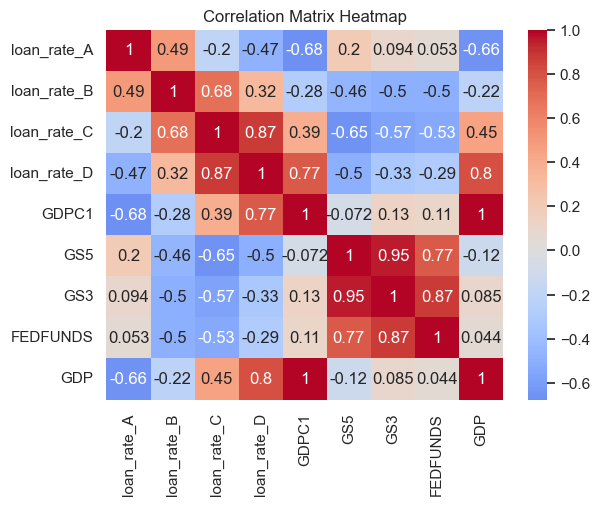

In [119]:
plot_corr_heatmap(df)

Correlations across First Differences.

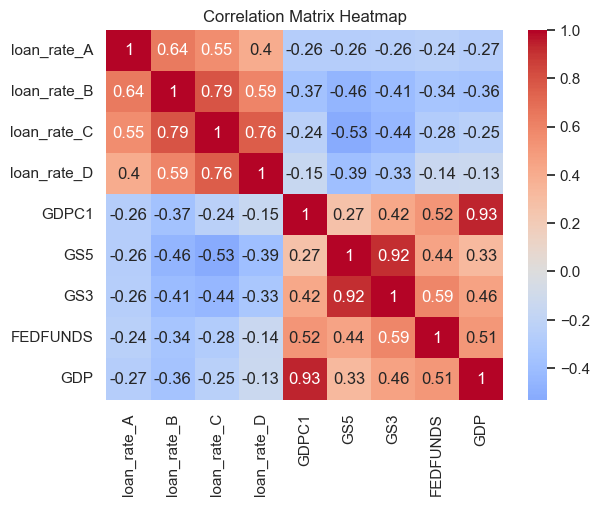

In [120]:
plot_corr_heatmap(df_diff)

Scatter Plots.

In [121]:
def plot_scatter_pairs(df):
    # Compute pairwise scatter plots
    sns.pairplot(df, kind='scatter')

    # Show plot
    plt.show()

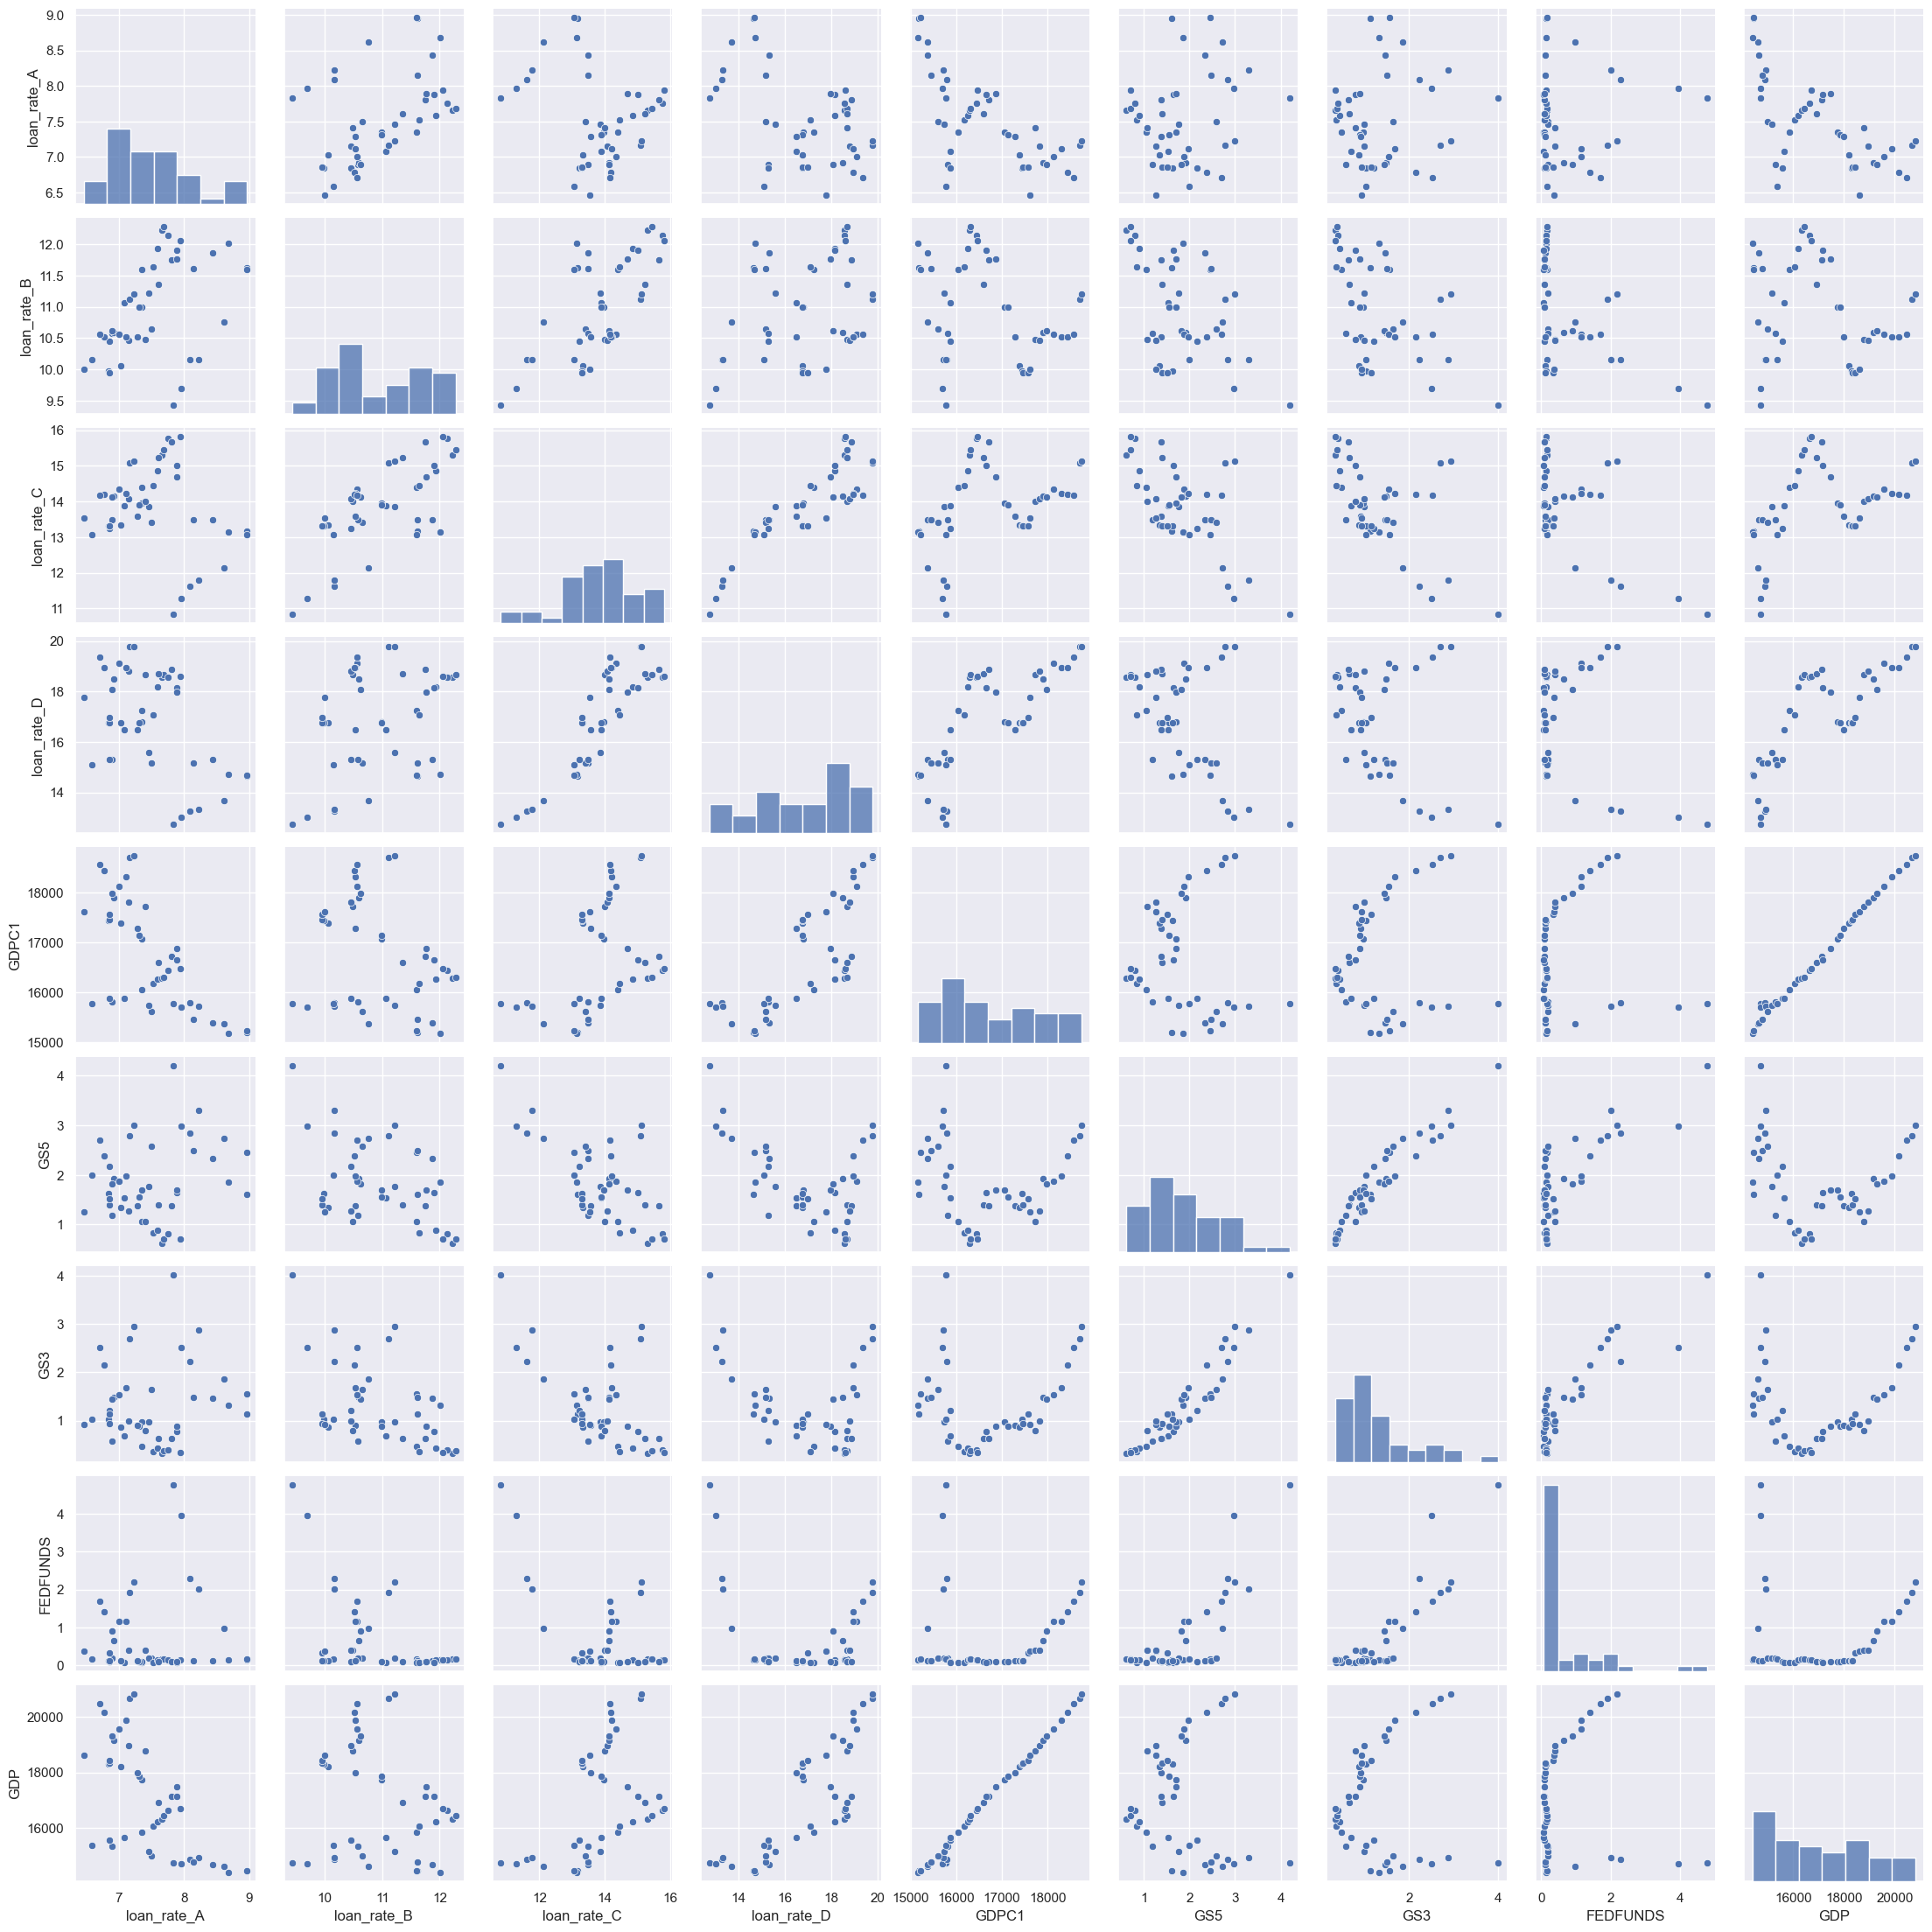

In [122]:
plot_scatter_pairs(df)

First Difference.

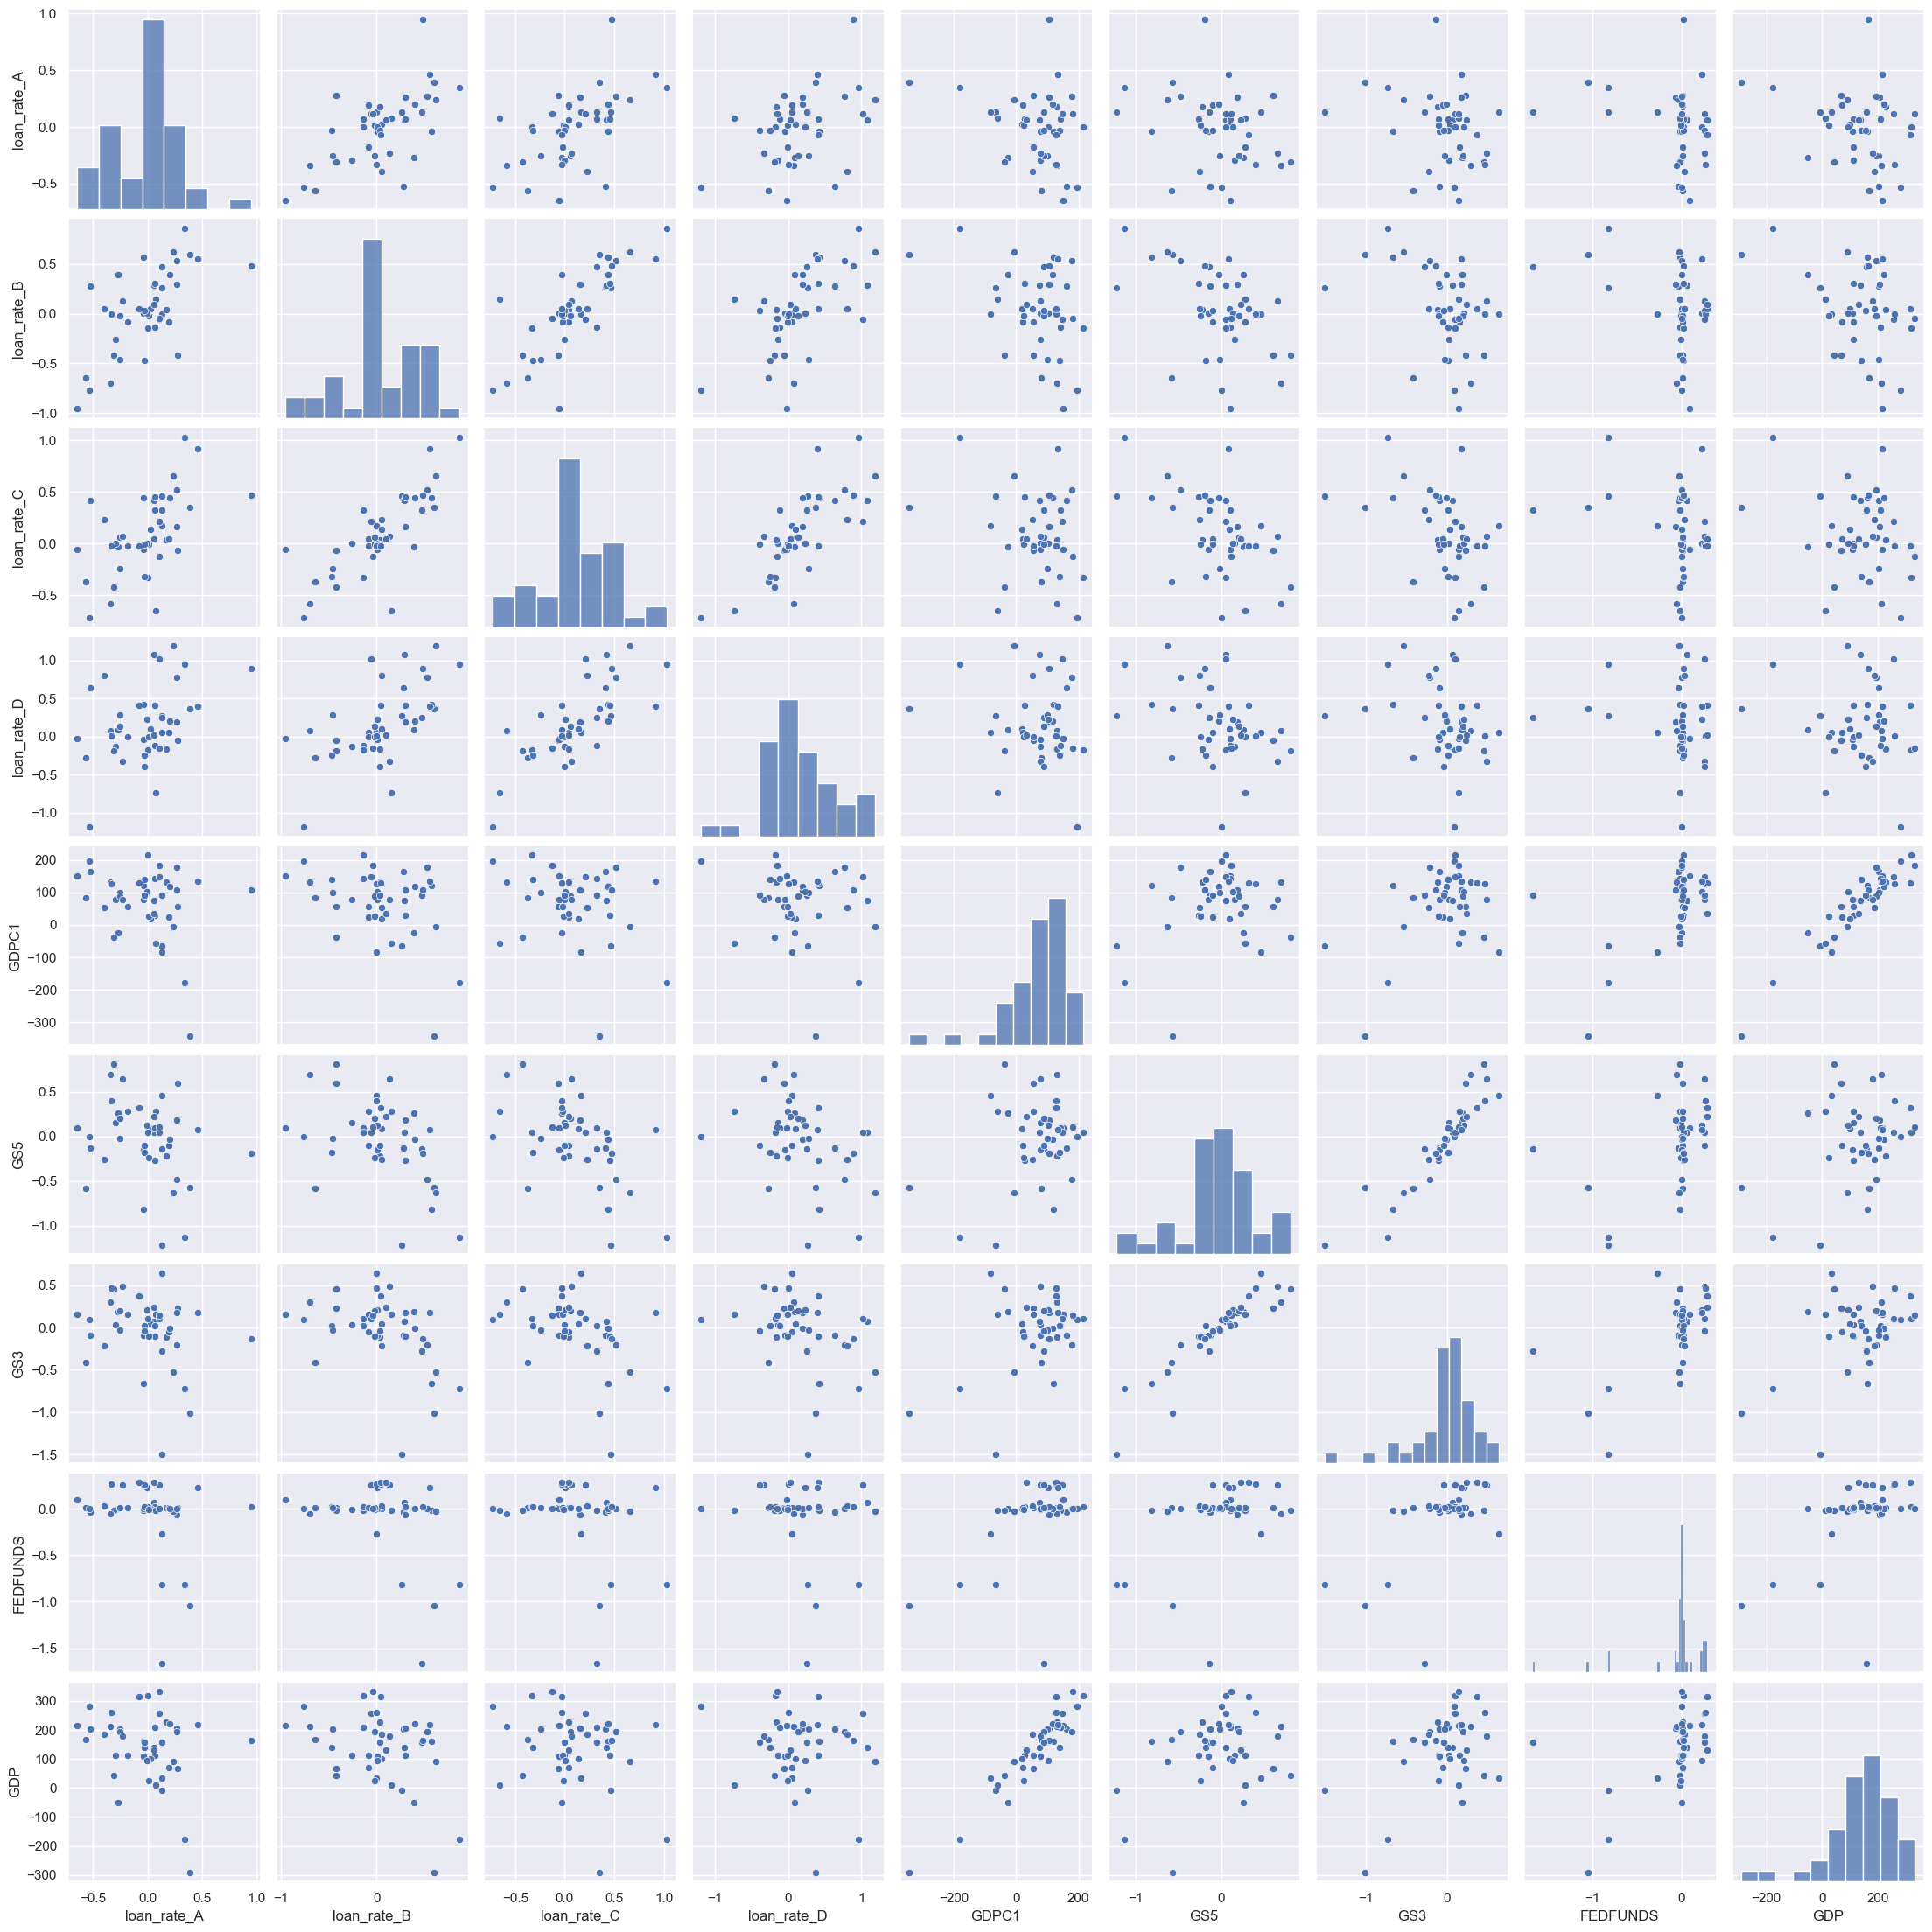

In [123]:
plot_scatter_pairs(df_diff)

### 4.2.3. Feature Selection

## 4.3. Model Methodology

## 4.4. Training Data

## 4.5. Model Training

## 4.6. Model Evaluation